# PSPec Run

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import h5py
from pyuvdata import UVCal, UVData

from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, Angle
import astropy.units as u
from scipy import signal
    
import hera_pspec as hp
from pyuvdata import UVCal
from hera_sim.beams import PolyBeam, PerturbedPolyBeam

/data/home/apw682/.local/lib/python3.7/site-packages/hera_sim-0.3.0-py3.7.egg/hera_sim/visibilities/__init__.py:27: UserWarning: PRISim failed to import.
  warnings.warn("PRISim failed to import.")
/data/home/apw682/.local/lib/python3.7/site-packages/hera_sim-0.3.0-py3.7.egg/hera_sim/visibilities/__init__.py:33: UserWarning: VisGPU failed to import.
  warnings.warn("VisGPU failed to import.")
/data/home/apw682/.local/lib/python3.7/site-packages/hera_sim-0.3.0-py3.7.egg/hera_sim/__init__.py:37: FutureWarning: 
In the next major release, all HERA-specific variables will be removed from the codebase. The following variables will need to be accessed through new class-like structures to be introduced in the next major release: 

noise.HERA_Tsky_mdl
noise.HERA_BEAM_POLY
sigchain.HERA_NRAO_BANDPASS
rfi.HERA_RFI_STATIONS

Additionally, the next major release will involve modifications to the package's API, which move toward a regularization of the way in which hera_sim methods are interfaced w

In [2]:
horizon_delay = (14.6 / 3.e8) * 1.e9 + 10
horizon_delay

58.666666666666664

# Array layout

In [3]:
dist = 14.6
ants = {}

for i in range(0, 4):
        ants.update([(i, (-3.*dist/2 + i*14.6, 0., 0.))])   
for i in range(4, 7):
        ants.update([(i, (-2.*dist/2 + (i-4)*14.6, -1.* np.sqrt(3) * dist/2, 0.))])   
for i in range(7, 10):
        ants.update([(i, (-2.*dist/2 + (i-7)*14.6, +1.* np.sqrt(3) * dist/2, 0.))])

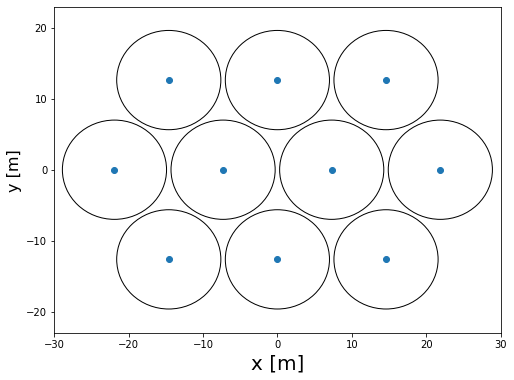

In [4]:
antscord = list(ants.values())[:]
antscord = np.array(antscord)

#circle1=plt.Circle((antscord[0,0],antscord[0,1]),2.0,color='b',fill=False)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.scatter(antscord[:,0],antscord[:,1])
for i in range(len(antscord)):
    circle1=plt.Circle((antscord[i,0],antscord[i,1]),7.0,color='k',fill=False)
    plt.gcf().gca().add_artist(circle1)
ax.set_xlabel('x [m]', fontsize=20)
ax.set_ylabel('y [m]',fontsize=16)
ax.set_xlim(-30,30)
ax.set_ylim(-23,23)
plt.savefig('array.pdf',bbox_inches='tight')

# Plotting the perturbed beam

In [5]:
# Best fit coeffcients for Chebyshev polynomials
coeff = np.array([ 0.29778665, -0.44821433,  0.27338272, -0.10030698, -0.01195859,
        0.06063853, -0.04593295,  0.0107879 ,  0.01390283, -0.01881641,
       -0.00177106,  0.01265177, -0.00568299, -0.00333975,  0.00452368,
        0.00151808, -0.00593812,  0.00351559])
spindex = -0.6975 #by power-law fitting of the width of Fagnoni beam at 100 and 200 MHz
freq0 = 1.e8

#no perturbation
beam_nopert = PolyBeam(beam_coeffs=coeff , spectral_index=spindex, ref_freq=freq0)

#sidelobe
np.random.seed(11)
nmodes = 8
pcoeffs0 = np.random.randn(nmodes)
pcoeffs1 = np.random.randn(nmodes)
sigma02 = 0.8

beam_side02_0 = PerturbedPolyBeam(pcoeffs0, perturb_scale=sigma02, mainlobe_width=0.3,
                              beam_coeffs=coeff, spectral_index=spindex, ref_freq=freq0)
beam_side02_1 = PerturbedPolyBeam(pcoeffs1, perturb_scale=sigma02, mainlobe_width=0.3,
                              beam_coeffs=coeff, spectral_index=spindex, ref_freq=freq0)

#mainlobe
beam_main098_0 = PerturbedPolyBeam(mainlobe_width=0.3, mainlobe_scale= 0.9,
                                   beam_coeffs=coeff, spectral_index=spindex, ref_freq=freq0)
beam_main102_1 = PerturbedPolyBeam(mainlobe_width=0.3, mainlobe_scale= 0.9,
                                   beam_coeffs=coeff, spectral_index=spindex, ref_freq=freq0)

#xstretch , ystretch same
beam_xystretch098_0 = PerturbedPolyBeam(mainlobe_width=0.3, xstretch=1.2, ystretch=1.2,
                                   beam_coeffs=coeff, spectral_index=spindex, ref_freq=freq0)
beam_xystretch102_1 = PerturbedPolyBeam(mainlobe_width=0.3, xstretch=1.2, ystretch=1.2,
                                   beam_coeffs=coeff, spectral_index=spindex, ref_freq=freq0)

#xstretch , ystretch diff
beam_xystretchdiff_0 = PerturbedPolyBeam(mainlobe_width=0.3, xstretch=0.9, ystretch=1.2,
                                   beam_coeffs=coeff, spectral_index=spindex, ref_freq=freq0)
beam_xystretchdiff_1 = PerturbedPolyBeam(mainlobe_width=0.3, xstretch=1.2, ystretch=0.9,
                                   beam_coeffs=coeff, spectral_index=spindex, ref_freq=freq0)

#xstretch , ystretch diff, rotation diff
beam_xystretchdiffrot_0 = PerturbedPolyBeam(mainlobe_width=0.3, xstretch=0.9, ystretch=1.2,rotation=0.,
                                   beam_coeffs=coeff, spectral_index=spindex, ref_freq=freq0)
beam_xystretchdiffrot_1 = PerturbedPolyBeam(mainlobe_width=0.3, xstretch=1.2, ystretch=0.9,rotation=135.,
                                   beam_coeffs=coeff, spectral_index=spindex, ref_freq=freq0)

In [6]:
import healpy
nside =32
Npixels = healpy.nside2npix(nside)
print(Npixels)
theta, phi = healpy.pix2ang(nside, np.arange(Npixels), nest=False, lonlat=False)

az = phi[theta < np.pi/2]
za = theta[theta < np.pi/2]

12288


In [7]:
uvd = UVData()
uvd.read_uvh5('calibration_catBC/viscatBC_side0.8_g.uvh5')

beam_nopert_interp = beam_nopert.interp(az,za,uvd.freq_array.flatten())
beam_side02_0_interp = beam_side02_0.interp(az,za,uvd.freq_array.flatten())
beam_side02_1_interp = beam_side02_1.interp(az,za,uvd.freq_array.flatten())
beam_main098_0_interp = beam_main098_0.interp(az,za,uvd.freq_array.flatten())
beam_main102_1_interp = beam_main102_1.interp(az,za,uvd.freq_array.flatten())
beam_xystretch098_0_interp = beam_xystretch098_0.interp(az,za,uvd.freq_array.flatten())
beam_xystretch102_1_interp = beam_xystretch102_1.interp(az,za,uvd.freq_array.flatten())
beam_xystretchdiff_0_interp = beam_xystretchdiff_0.interp(az,za,uvd.freq_array.flatten())
beam_xystretchdiff_1_interp = beam_xystretchdiff_1.interp(az,za,uvd.freq_array.flatten())
beam_xystretchdiffrot_0_interp = beam_xystretchdiffrot_0.interp(az,za,uvd.freq_array.flatten())
beam_xystretchdiffrot_1_interp = beam_xystretchdiffrot_1.interp(az,za,uvd.freq_array.flatten())

pb_nopert_hp=np.zeros(Npixels)
pb_side02_0_hp=np.zeros(Npixels)
pb_side02_1_hp=np.zeros(Npixels)
pb_main098_0_hp = np.zeros(Npixels)
pb_main102_1_hp = np.zeros(Npixels)
pb_xystretch098_0_hp = np.zeros(Npixels)
pb_xystretch102_1_hp = np.zeros(Npixels)
pb_xystretchdiff_0_hp = np.zeros(Npixels)
pb_xystretchdiff_1_hp = np.zeros(Npixels)
pb_xystretchdiffrot_0_hp = np.zeros(Npixels)
pb_xystretchdiffrot_1_hp = np.zeros(Npixels)


for n,th in enumerate(za):
    pb_nopert_hp[np.where(theta==th)]=beam_nopert_interp[0][1][0][0][0][n]
    pb_side02_0_hp[np.where(theta==th)]=beam_side02_0_interp[0][1][0][0][0][n]
    pb_side02_1_hp[np.where(theta==th)]=beam_side02_1_interp[0][1][0][0][0][n]
    pb_main098_0_hp[np.where(theta==th)]=beam_main098_0_interp[0][1][0][0][0][n]
    pb_main102_1_hp[np.where(theta==th)]=beam_main102_1_interp[0][1][0][0][0][n]
    pb_xystretch098_0_hp[np.where(theta==th)]=beam_xystretch098_0_interp[0][1][0][0][0][n]
    pb_xystretch102_1_hp[np.where(theta==th)]=beam_xystretch102_1_interp[0][1][0][0][0][n]
    pb_xystretchdiff_0_hp[np.where(theta==th)]=beam_xystretchdiff_0_interp[0][1][0][0][0][n]
    pb_xystretchdiff_1_hp[np.where(theta==th)]=beam_xystretchdiff_1_interp[0][1][0][0][0][n]
    pb_xystretchdiffrot_0_hp[np.where(theta==th)]=beam_xystretchdiffrot_0_interp[0][1][0][0][0][n]
    pb_xystretchdiffrot_1_hp[np.where(theta==th)]=beam_xystretchdiffrot_1_interp[0][1][0][0][0][n]
    

Telescope hera_sim is not in known_telescopes.


divide by zero encountered in log10
divide by zero encountered in log10
divide by zero encountered in log10
divide by zero encountered in log10
divide by zero encountered in log10
divide by zero encountered in log10


0.0 180.0 -180.0 180.0
The interval between parallels is 20 deg 0.00'.
The interval between meridians is 90 deg 0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 20 deg 0.00'.
The interval between meridians is 90 deg 0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 20 deg 0.00'.
The interval between meridians is 90 deg 0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 20 deg 0.00'.
The interval between meridians is 90 deg 0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 20 deg 0.00'.
The interval between meridians is 90 deg 0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 20 deg 0.00'.
The interval between meridians is 90 deg 0.00'.


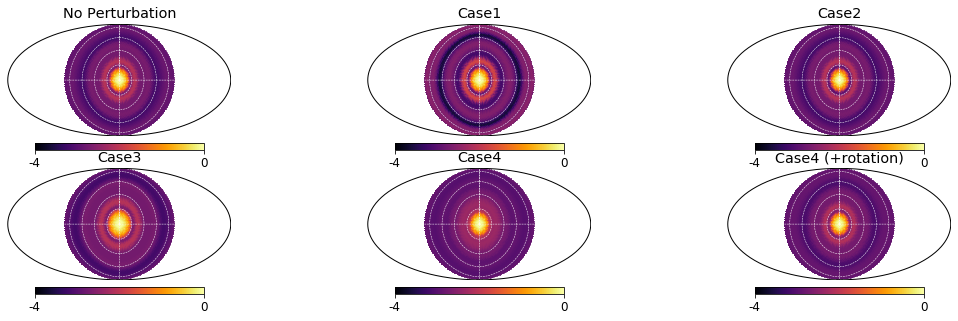

In [8]:
import matplotlib

matplotlib.rcParams.update({'font.size':12})
fig = plt.figure(figsize=(15, 4))
healpy.mollview(np.log10(pb_nopert_hp*pb_nopert_hp),sub=(2,3,1),rot=(0., 90., 0.),cmap='inferno',
                min=-4,max=0,title=r'No Perturbation')
healpy.mollview(np.log10(pb_side02_0_hp*pb_side02_1_hp), sub=(2,3,2),rot=(0., 90., 0.),cmap='inferno',
                min=-4,max=0,title=r'Case1')
healpy.mollview(np.log10(pb_main098_0_hp*pb_main102_1_hp), sub=(2,3,3),rot=(0., 90., 0.),cmap='inferno',
                min=-4,max=0,title=r'Case2')
healpy.mollview(np.log10(pb_xystretch098_0_hp*pb_xystretch102_1_hp), sub=(2,3,4),rot=(0., 90., 0.),cmap='inferno',
                min=-4,max=0,title=r'Case3')
healpy.mollview(np.log10(pb_xystretchdiff_0_hp*pb_xystretchdiff_1_hp), sub=(2,3,5),rot=(0., 90., 0.),cmap='inferno',
                min=-4,max=0,title=r'Case4')
healpy.mollview(np.log10(pb_xystretchdiffrot_0_hp*pb_xystretchdiffrot_1_hp), sub=(2,3,6),rot=(0., 90., 0.),cmap='inferno',
                min=-4,max=0,title=r'Case4 (+rotation)')

healpy.graticule(20.,90.,ls='--',color='white',lw=0.5)

divide by zero encountered in log10
invalid value encountered in true_divide
invalid value encountered in less_equal
invalid value encountered in less
invalid value encountered in greater
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


0.0 180.0 -180.0 180.0
The interval between parallels is 20 deg 0.00'.
The interval between meridians is 90 deg 0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 20 deg 0.00'.
The interval between meridians is 90 deg 0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 20 deg 0.00'.
The interval between meridians is 90 deg 0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 20 deg 0.00'.
The interval between meridians is 90 deg 0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 20 deg 0.00'.
The interval between meridians is 90 deg 0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 20 deg 0.00'.
The interval between meridians is 90 deg 0.00'.


invalid value encountered in less
invalid value encountered in greater
invalid value encountered in less
invalid value encountered in greater


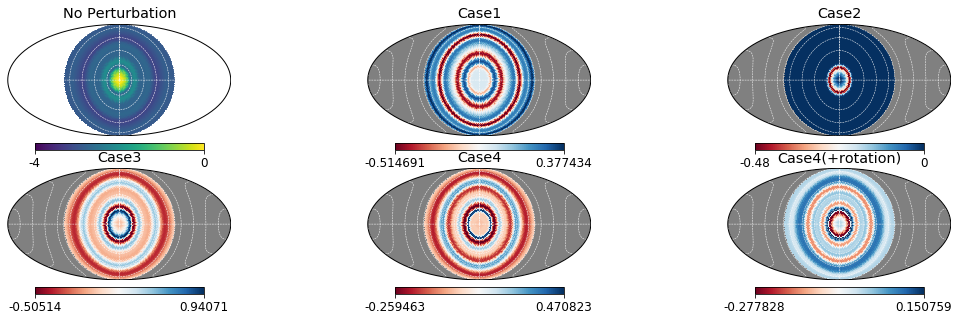

In [9]:
fig = plt.figure(figsize=(15, 4))
healpy.mollview(np.log10(pb_nopert_hp*pb_nopert_hp),sub=(2,3,1),rot=(0., 90., 0.),
                min=-4,max=0,title=r'No Perturbation')
healpy.mollview(np.log10((pb_side02_0_hp*pb_side02_1_hp)/(pb_nopert_hp*pb_nopert_hp)), sub=(2,3,2),rot=(0., 90., 0.),cmap='RdBu',
                title=r'Case1')
healpy.mollview(np.log10((pb_main098_0_hp*pb_main102_1_hp)/(pb_nopert_hp*pb_nopert_hp)),
                sub=(2,3,3),rot=(0., 90., 0.),cmap='RdBu',min=-0.48,
                title=r'Case2')
healpy.mollview(np.log10((pb_xystretch098_0_hp*pb_xystretch102_1_hp)/(pb_nopert_hp*pb_nopert_hp)), sub=(2,3,4),rot=(0., 90., 0.),cmap='RdBu',
               title=r'Case3')
healpy.mollview(np.log10((pb_xystretchdiff_0_hp*pb_xystretchdiff_1_hp)/(pb_nopert_hp*pb_nopert_hp)), sub=(2,3,5),rot=(0., 90., 0.),cmap='RdBu',
               title=r'Case4')
healpy.mollview(np.log10((pb_xystretchdiffrot_0_hp*pb_xystretchdiffrot_1_hp)/(pb_nopert_hp*pb_nopert_hp)), sub=(2,3,6),rot=(0., 90., 0.),cmap='RdBu',
                title=r'Case4(+rotation)')

healpy.graticule(20.,90.,ls='--',color='white',lw=0.5)
plt.savefig('beam_hp.pdf',bbox_inches='tight')

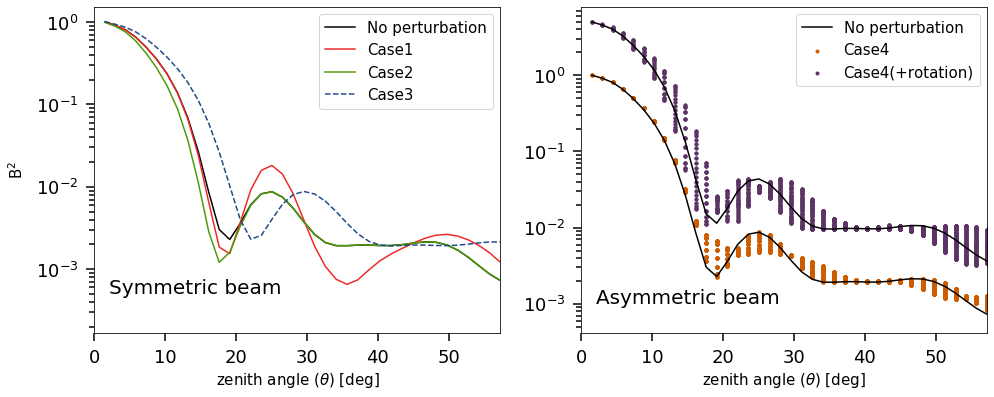

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

ax[0].plot(np.rad2deg(za),(beam_nopert_interp[0][1][0][0][0]*beam_nopert_interp[0][1][0][0][0]),'k',
           label=r'No perturbation')
ax[0].plot(np.rad2deg(za),(beam_side02_0_interp[0][1][0][0][0]*beam_side02_1_interp[0][1][0][0][0]),'#ef2929',
           label=r'Case1')#red
ax[0].plot(np.rad2deg(za),(beam_main098_0_interp[0][1][0][0][0]*beam_main102_1_interp[0][1][0][0][0]),'#4e9a06',
           label=r'Case2')#green
ax[0].plot(np.rad2deg(za),(beam_xystretch098_0_interp[0][1][0][0][0]*beam_xystretch102_1_interp[0][1][0][0][0]),
           '#204a87',ls='--',label=r'Case3')#blue
ax[0].set_xlim([0.,np.rad2deg(1.)])
ax[0].set_ylabel('B$^2$', fontsize=15,labelpad=10)
ax[0].text(2, 0.5e-3,r'Symmetric beam', fontsize=20)
ax[0].set_xlabel(r'zenith angle ($\theta$) [deg]', fontsize=15)
ax[0].set_yscale('log')
ax[0].legend(fontsize=15)
ax[0].tick_params(axis='both', which='major', labelsize=18, size=8., width=1.5, pad=8.)
ax[0].tick_params(axis='both', which='minor', labelsize=18, size=5., width=1.5, pad=8.)

ax[1].plot(np.rad2deg(za),(beam_nopert_interp[0][1][0][0][0]*beam_nopert_interp[0][1][0][0][0]),'k',
           label=r'No perturbation')
ax[1].scatter(np.rad2deg(za),(beam_xystretchdiff_0_interp[0][1][0][0][0]*beam_xystretchdiff_1_interp[0][1][0][0][0]),
           color='#ce5c00',marker='.',label=r'Case4')#orange
ax[1].plot(np.rad2deg(za),5.*(beam_nopert_interp[0][1][0][0][0]*beam_nopert_interp[0][1][0][0][0]),'k',
           label='')
ax[1].scatter(np.rad2deg(za),5.*(beam_xystretchdiffrot_0_interp[0][1][0][0][0]*
                           beam_xystretchdiffrot_1_interp[0][1][0][0][0]),color='#5c3566',marker='.',
              label=r'Case4(+rotation)')#plum
ax[1].set_xlim([0.,np.rad2deg(1.)])
ax[1].text(2, 1.e-3,r'Asymmetric beam', fontsize=20)
#ax[1].set_ylabel('B', fontsize=16)
ax[1].set_xlabel(r'zenith angle ($\theta$) [deg]', fontsize=15)
ax[1].set_yscale('log')
ax[1].legend(fontsize=15)
ax[1].tick_params(axis='both', which='major', labelsize=18, size=8., width=1.5, pad=8.)
ax[1].tick_params(axis='both', which='minor', labelsize=18, size=5., width=1.5, pad=8.)


plt.savefig('perturb_beam.pdf',bbox_inches='tight')

# Source track

In [11]:
hera_lon='21d25m41.9s'
hera_lat='-30d43m17.5s'
hera_height=1073
hera_location = EarthLocation(lat=Angle(hera_lat).degree, lon=Angle(hera_lon).degree, height=hera_height*u.m)

In [12]:
time=np.unique(uvd.time_array)
obs_t=Time(time, format='jd')

In [13]:
lsts=Time(time, format='jd',location=hera_location)
cblst = lsts.sidereal_time('mean').hour

In [14]:
aa = np.genfromtxt('../pb_hera_bakup/catBC.txt', usecols=(0,1,2)) 
bb = aa[aa[:,2].argsort()[::-1]][0:20]
ra = np.deg2rad(bb[:,0])
dec = np.deg2rad(bb[:,1])

In [15]:
frame_altaz = AltAz(obstime=obs_t,location=hera_location)
    
l1 = []
m1 = []
for RA_rad, Dec_rad in zip(ra,dec):
    coord_radec = SkyCoord(ra=RA_rad*u.rad, dec=Dec_rad*u.rad, frame='icrs')
    coord_altaz = coord_radec.transform_to(frame_altaz)

    az=Angle(coord_altaz.az).radian
    alt=Angle(coord_altaz.alt).radian
    za=(np.pi/2)-alt

    za[za > np.pi/2] = np.nan
    az[za > np.pi/2] = np.nan

    l1.append(np.sin(za)*np.cos(az))
    m1.append(np.sin(za)*np.sin(az))
    
l1 = np.array(l1)
m1 = np.array(m1)

invalid value encountered in greater


In [16]:
Npixels_hires=healpy.nside2npix(128)
theta_hires, phi_hires = healpy.pix2ang(128, np.arange(Npixels_hires), nest=False, lonlat=False)

theta_hires[theta_hires > np.pi/2] = np.nan
phi_hires[theta_hires > np.pi/2] = np.nan

l_hires=np.sin(theta_hires)*np.cos(phi_hires)
m_hires=np.sin(theta_hires)*np.sin(phi_hires)

invalid value encountered in greater


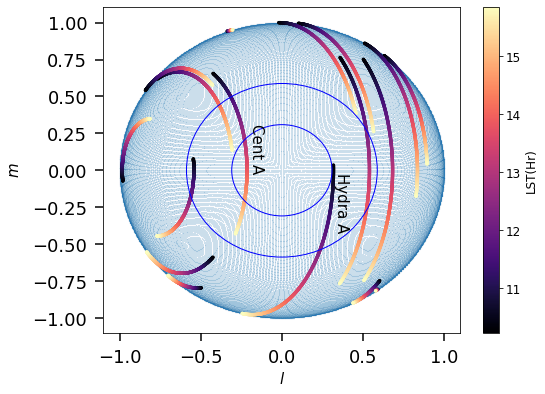

In [17]:
circle1=plt.Circle((0,0),np.sin(np.deg2rad(18)),color='b',fill=False)
circle2=plt.Circle((0,0),np.sin(np.deg2rad(36)),color='b',fill=False)

fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(l_hires, m_hires, s=0.005)
ax.add_artist(circle1)
ax.add_artist(circle2)
for i in range(len(l1)): #len(l1) number of sources
    plt.scatter(l1[i], m1[i], s=5.5,c=cblst,cmap='magma')
ax.set_ylabel(r'$\it{m}$', fontsize=15,labelpad=10)
ax.set_xlabel(r'$\it{l}$', fontsize=15)
ax.text(-0.2, 0.,r'Cent A', fontsize=15,color='k',rotation=270)
ax.text(0.32, -0.4,r'Hydra A', fontsize=15,color='k',rotation=270)


plt.colorbar(label='LST(Hr)')
ax.tick_params(axis='both', which='major', labelsize=18, size=8., width=1.5, pad=8.)
ax.tick_params(axis='both', which='minor', labelsize=18, size=5., width=1.5, pad=8.)
plt.savefig('track.pdf',bbox_inches='tight')

# Gain Power Spectrum

In [18]:
def gain_PS(gainfile, ax=None, set_secax=False, color=None, ls=None, label=None):
    
    uvc = UVCal()
    uvc.read_calfits(gainfile)
    window = signal.blackmanharris(len(uvc.time_array))
    gain = uvc.gain_array[:,0,:,:,0]
    gain_win = gain * window
    gain_win_fft = np.fft.fftshift(np.fft.fft(gain_win), axes=2)
    gain_ps = gain_win_fft * gain_win_fft.conjugate()
    freqs = np.fft.fftshift(np.fft.fftfreq(len(uvc.time_array), d=40))
    
    beam_timescale = 1/(1.*40*60) #40 min

    ax.plot(freqs,np.average(gain_ps,axis=(0,1)), lw=3, color=color, ls=ls, label=label)
    ax.axvline(x=beam_timescale, ymin=0, ymax=1,color='k',ls='--')

    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_ylabel(r'gain PS', fontsize=25,labelpad=10)
    ax.set_xlabel(r'Inverse Timescale (Hz)', fontsize=25)
    ax.tick_params(axis='both', which='major', labelsize=18, size=8., width=1.5, pad=8.)
    ax.tick_params(axis='both', which='minor', labelsize=18, size=5., width=1.5, pad=8.)
    ax.legend(loc='upper right',fontsize=18)
   
    def freq2time(x):
        return 1./(x*60)


    def time2freq(x):
        return 1./(x*60)

    if set_secax:
        secax = ax.secondary_xaxis('top', functions=(freq2time, time2freq))
        secax.set_xlabel(r'Time [min]', fontsize=25)
        secax.tick_params(axis='both', which='major', labelsize=18, size=8., width=1.5, pad=8.)
        secax.tick_params(axis='both', which='minor', labelsize=18, size=5., width=1.5, pad=8.)
        #return fig    

Casting complex values to real discards the imaginary part
overflow encountered in power
Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part
Casting complex values to 

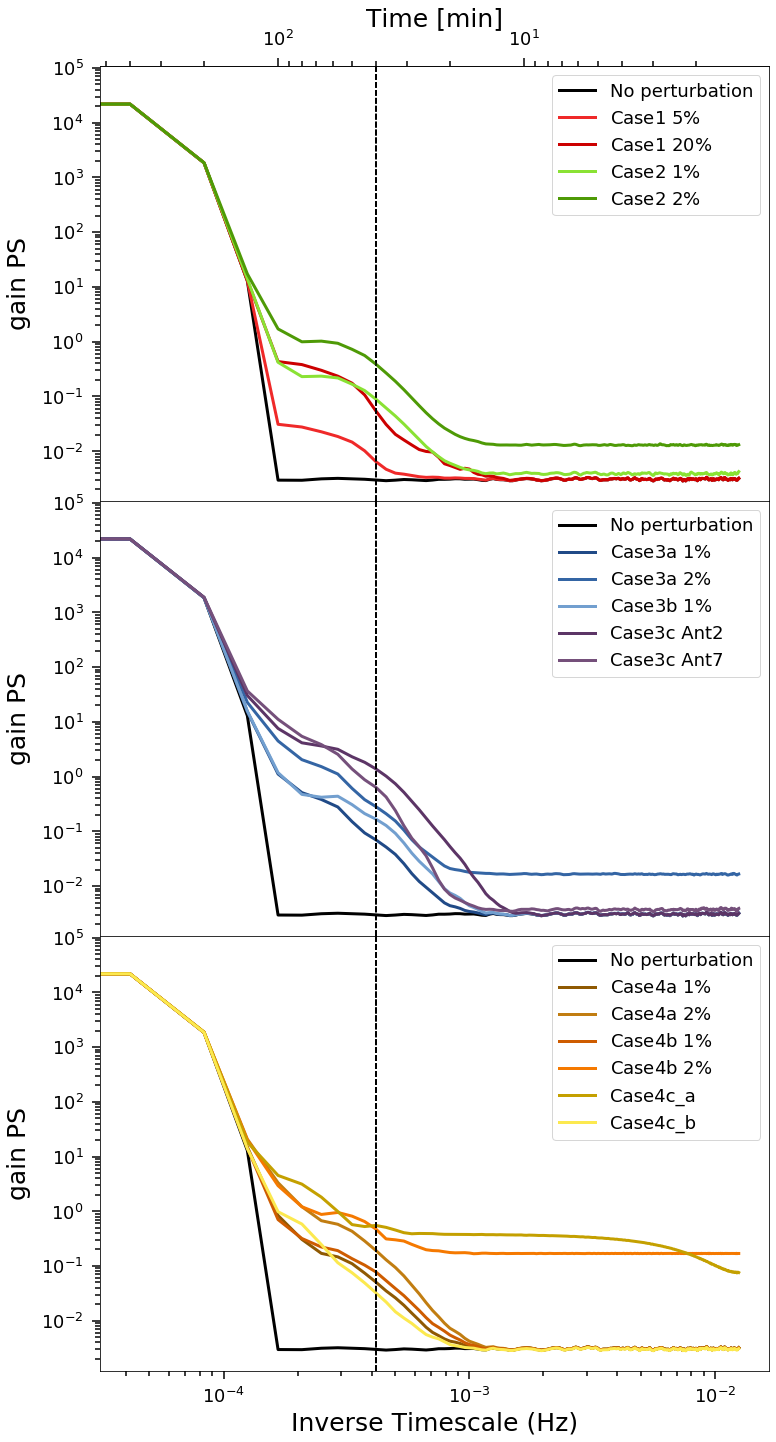

In [19]:
fig, ax = plt.subplots(3, 1, sharex=True,figsize=(12, 24))

gain_PS("calibration_catBC/viscatBC_g_new.calfits",ax=ax[0],set_secax=True,color='k',label=r'No perturbation')
gain_PS("calibration_catBC/viscatBC_side0.05_g_new.calfits",ax=ax[0],color='#ef2929',label=r'Case1 $5\%$')
gain_PS("calibration_catBC/viscatBC_side0.2_g_new.calfits",ax=ax[0],color='#cc0000',label=r'Case1 $20\%$')
gain_PS("calibration_catBC/viscatBC_main001_g_new.calfits",ax=ax[0],color='#8ae234',label=r'Case2 $1\%$')
gain_PS("calibration_catBC/viscatBC_main002_g_new.calfits",ax=ax[0],color='#4e9a06',label=r'Case2 $2\%$')

gain_PS("calibration_catBC/viscatBC_g_new.calfits",ax=ax[1],color='k',label=r'No perturbation')
gain_PS("calibration_catBC/viscatBC_stretch0.01_g_new.calfits",ax=ax[1],color='#204a87',
        label=r'Case3a $1\%$')
gain_PS("calibration_catBC/viscatBC_stretch0.02_g_new.calfits",ax=ax[1],color='#3465a4',
        label=r'Case3a $2\%$')
gain_PS("calibration_catBC/viscatBC_unistretch0.01_g_new.calfits",ax=ax[1],color='#729fcf',
        label=r'Case3b $1\%$')
gain_PS("calibration_catBC/viscatBC_outlier2_1.1_g_new.calfits",ax=ax[1],color='#5c3566',label=r'Case3c Ant2')
gain_PS("calibration_catBC/viscatBC_outlier7_1.1_g_new.calfits",ax=ax[1],color='#75507b',label=r'Case3c Ant7')

gain_PS("calibration_catBC/viscatBC_g_new.calfits",color='k',ax=ax[2],label=r'No perturbation')
gain_PS("calibration_catBC/viscatBC_4a_0.01_g_new.calfits",ax=ax[2],color='#8f5902',label=r'Case4a $1\%$')
gain_PS("calibration_catBC/viscatBC_4a_0.02_g_new.calfits",ax=ax[2],color='#c17d11',label=r'Case4a $2\%$')
gain_PS("calibration_catBC/viscatBC_4b_0.01_g_new.calfits",ax=ax[2],color='#ce5c00',label=r'Case4b $1\%$')
gain_PS("calibration_catBC/viscatBC_4b_0.02_g_new.calfits",ax=ax[2],color='#f57900',label=r'Case4b $2\%$')
gain_PS("calibration_catBC/viscatBC_4c_a_g_new.calfits",ax=ax[2],color='#c4a000',label=r'Case4c_a')
gain_PS("calibration_catBC/viscatBC_4c_b_g_new.calfits",ax=ax[2],color='#fce94f',label=r'Case4c_b')
#gain_PS("calibration/viscatBC_5_g_new.calfits",ax=fig.gca(),color='#2e3436',ls='--',label=r'Case5')

plt.subplots_adjust(hspace=0)
plt.savefig('gainps.pdf',bbox_inches='tight')

In [20]:
def plot_diff_inco_co_from_pspeccon_stat_real(pspeccon_inco,pspeccon_co,ymin=None,ymax=None,label=None,color=None,
                                              ax=None):

    #incoherent PS
    psc = hp.PSpecContainer(pspeccon_inco)
    uvp = psc.get_pspec('dset0_dset1')
    blpairs = uvp[0].get_red_blpairs()[0]
    
    uvp2 = uvp[0].average_spectra(blpair_groups=blpairs, time_avg=False, inplace=False)
    spw = 0
    blp = uvp2.get_red_blpairs()[0][0][0]
    key = (spw, blp, 'xx')
    dlys = uvp2.get_dlys(spw) * 1e9
    #power_inco  = np.abs(np.real(uvp2.get_data(key)))
    power_inco  = (uvp2.get_data(key))
    
    #incoherent PS time averaging
    #...............
    uvp2 = uvp[0].average_spectra(blpair_groups=blpairs, time_avg=True, inplace=False)
    spw = 0
    blp = uvp2.get_red_blpairs()[0][0][0]
    key = (spw, blp, 'xx')
    dlys = uvp2.get_dlys(spw) * 1e9
    #power_inco_avg = np.abs(np.real(uvp2.get_data(key)))
    power_inco_avg = (uvp2.get_data(key))
    
    #coherent PS
    psc = hp.PSpecContainer(pspeccon_co)
    uvp = psc.get_pspec('dset0_dset1')
    blpairs = uvp[0].get_red_blpairs()[0]
    
    uvp2 = uvp[0].average_spectra(blpair_groups=blpairs, time_avg=False, inplace=False)
    spw = 0
    blp = uvp2.get_red_blpairs()[0][0][0]
    key = (spw, blp, 'xx')
    dlys = uvp2.get_dlys(spw) * 1e9
    #power_co = np.abs(np.real(uvp2.get_data(key))) 
    power_co = (uvp2.get_data(key))
    
    # Create new Axes if none specified
    new_plot = False
    if ax is None:
        new_plot = True
        fig, ax = plt.subplots(figsize=(12,8))

    lsts = uvp2.time_avg_array
    nlsts = lsts.size
    
    obs_t=Time(lsts, format='jd',location=hera_location)
    lsts_hr = obs_t.sidereal_time('mean').hour
    
    ratio = np.real((power_co - power_inco)/power_inco_avg)
    ax.autoscale() # Need this to rescale the axes


    ax.plot(lsts_hr,(ratio[:,60])*100.,lw=2,color=color,label=label)
    ax.set_ylabel(r"% of $\frac{P^{\tau=0}_{co} - P^{\tau=0}_{inco}}{<P^{\tau=0}_{inco}>}$, Real", fontsize=25,labelpad=10)
    ax.set_xlabel("LST [Hr]", fontsize=25)
    ax.set_ylim(ymin,ymax)
    ax.tick_params(axis='both', which='major', labelsize=18, size=8., width=1.5, pad=8.)
    ax.tick_params(axis='both', which='minor', labelsize=18, size=5., width=1.5, pad=8.)
    ax.legend(loc='lower left',fontsize=18)
    
    if new_plot:
        return fig

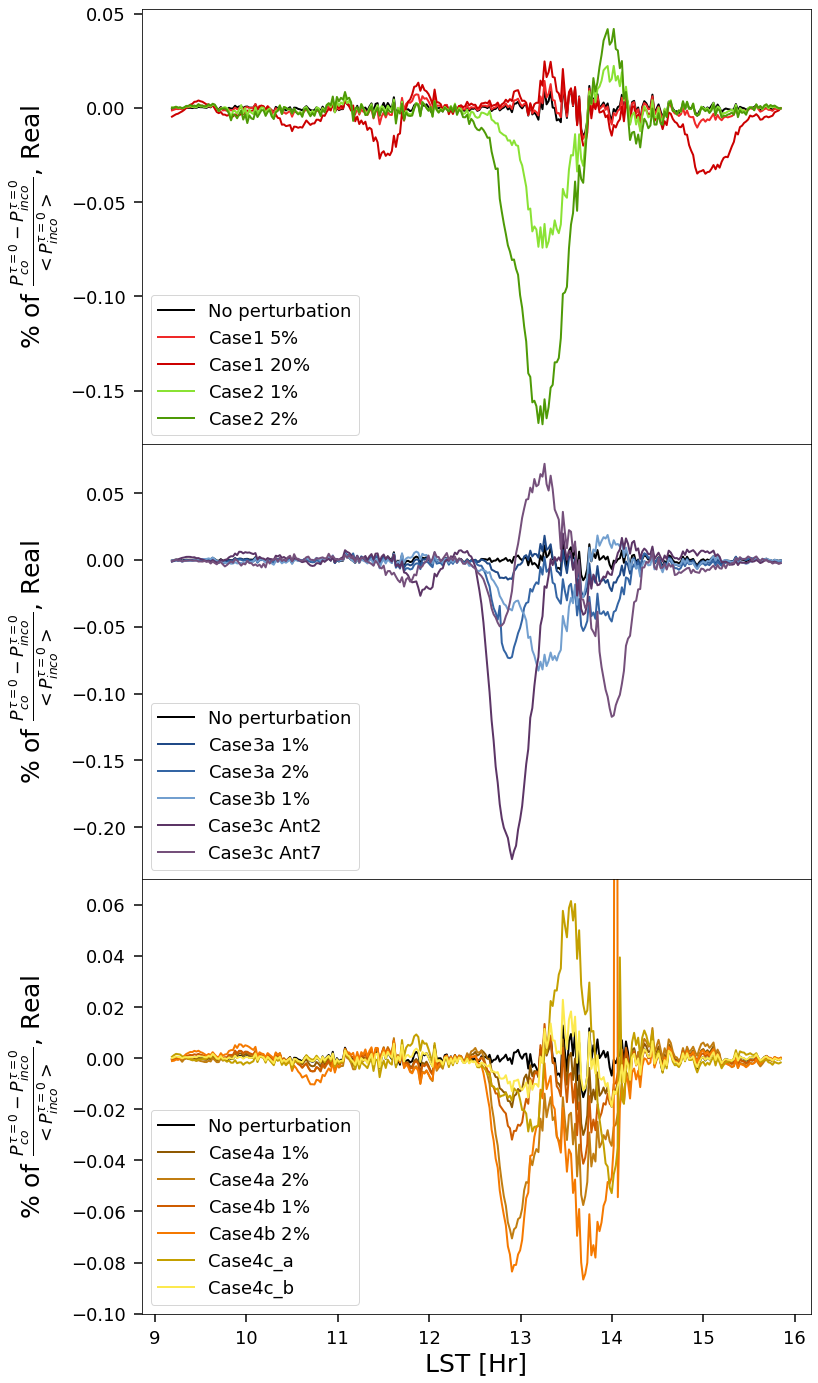

In [21]:
fig, ax = plt.subplots(3, 1, sharex=True,figsize=(12, 24))

plot_diff_inco_co_from_pspeccon_stat_real("calibration.realiz/viscatBC_g.inco_psc.hdf5",
                                      "calibration.realiz/viscatBC_g.co_psc.hdf5",
                                     ax=ax[0],color='k',label=r'No perturbation')
plot_diff_inco_co_from_pspeccon_stat_real("calibration.realiz/viscatBC_side0.05_g.inco_psc.hdf5",
                                      "calibration.realiz/viscatBC_side0.05_g.co_psc.hdf5",
                                     ax=ax[0],color='#ef2929',label=r'Case1 $5\%$')
plot_diff_inco_co_from_pspeccon_stat_real("calibration.realiz/viscatBC_side0.2_g.inco_psc.hdf5",
                                      "calibration.realiz/viscatBC_side0.2_g.co_psc.hdf5",
                                          ax=ax[0],color='#cc0000',label=r'Case1 $20\%$')
plot_diff_inco_co_from_pspeccon_stat_real("calibration.realiz/viscatBC_main001_g.inco_psc.hdf5",
                                      "calibration.realiz/viscatBC_main001_g.co_psc.hdf5",
                                          ax=ax[0],color='#8ae234',label=r'Case2 $1\%$')
plot_diff_inco_co_from_pspeccon_stat_real("calibration.realiz/viscatBC_main002_g.inco_psc.hdf5",
                                      "calibration.realiz/viscatBC_main002_g.co_psc.hdf5",
                                          ax=ax[0],color='#4e9a06',label=r'Case2 $2\%$')


plot_diff_inco_co_from_pspeccon_stat_real("calibration.realiz/viscatBC_g.inco_psc.hdf5",
                                      "calibration.realiz/viscatBC_g.co_psc.hdf5",
                                     ax=ax[1],color='k',label=r'No perturbation')
plot_diff_inco_co_from_pspeccon_stat_real("calibration.realiz/viscatBC_stretch0.01_g.inco_psc.hdf5",
                                      "calibration.realiz/viscatBC_stretch0.01_g.co_psc.hdf5",
                                          ax=ax[1],color='#204a87',label=r'Case3a $1\%$')
plot_diff_inco_co_from_pspeccon_stat_real("calibration.realiz/viscatBC_stretch0.02_g.inco_psc.hdf5",
                                      "calibration.realiz/viscatBC_stretch0.02_g.co_psc.hdf5",
                                          ax=ax[1],color='#3465a4',label=r'Case3a $2\%$')
plot_diff_inco_co_from_pspeccon_stat_real("calibration.realiz/viscatBC_unistretch0.01_g.inco_psc.hdf5",
                                      "calibration.realiz/viscatBC_unistretch0.01_g.co_psc.hdf5",
                                          ax=ax[1],color='#729fcf',label=r'Case3b $1\%$')
plot_diff_inco_co_from_pspeccon_stat_real("calibration.realiz/viscatBC_outlier2_1.1_g.inco_psc.hdf5",
                                      "calibration.realiz/viscatBC_outlier2_1.1_g.co_psc.hdf5",
                                          ax=ax[1],color='#5c3566',label=r'Case3c Ant2')
plot_diff_inco_co_from_pspeccon_stat_real("calibration.realiz/viscatBC_outlier7_1.1_g.inco_psc.hdf5",
                                      "calibration.realiz/viscatBC_outlier7_1.1_g.co_psc.hdf5",
                                          ax=ax[1],color='#75507b',label=r'Case3c Ant7')

plot_diff_inco_co_from_pspeccon_stat_real("calibration.realiz/viscatBC_g.inco_psc.hdf5",
                                      "calibration.realiz/viscatBC_g.co_psc.hdf5",
                                     ax=ax[2],color='k',label=r'No perturbation')
plot_diff_inco_co_from_pspeccon_stat_real("calibration.realiz/viscatBC_4a_0.01_g.inco_psc.hdf5",
                                      "calibration.realiz/viscatBC_4a_0.01_g.co_psc.hdf5",
                                          ax=ax[2],color='#8f5902',label=r'Case4a $1\%$')
plot_diff_inco_co_from_pspeccon_stat_real("calibration.realiz/viscatBC_4a_0.02_g.inco_psc.hdf5",
                                      "calibration.realiz/viscatBC_4a_0.02_g.co_psc.hdf5",
                                          ax=ax[2],color='#c17d11',label=r'Case4a $2\%$')
plot_diff_inco_co_from_pspeccon_stat_real("calibration.realiz/viscatBC_4b_0.01_g.inco_psc.hdf5",
                                      "calibration.realiz/viscatBC_4b_0.01_g.co_psc.hdf5",
                                          ax=ax[2],color='#ce5c00',label=r'Case4b $1\%$')
plot_diff_inco_co_from_pspeccon_stat_real("calibration.realiz/viscatBC_4b_0.02_g.inco_psc.hdf5",
                                      "calibration.realiz/viscatBC_4b_0.02_g.co_psc.hdf5",
                                          ax=ax[2],color='#f57900',label=r'Case4b $2\%$')
plot_diff_inco_co_from_pspeccon_stat_real("calibration.realiz/viscatBC_4c_a_g.inco_psc.hdf5",
                                      "calibration.realiz/viscatBC_4c_a_g.co_psc.hdf5",
                                          ax=ax[2],color='#c4a000',label=r'Case4c_a')
plot_diff_inco_co_from_pspeccon_stat_real("calibration.realiz/viscatBC_4c_b_g.inco_psc.hdf5",
                                      "calibration.realiz/viscatBC_4c_b_g.co_psc.hdf5",
                                          ax=ax[2],color='#fce94f',label=r'Case4c_b',ymin=-0.1,ymax=0.07)

plt.subplots_adjust(hspace=0)
plt.savefig('decorr_real.pdf',bbox_inches='tight')

In [22]:
def plot_diff_inco_co_from_pspeccon_stat_imag(pspeccon_inco,pspeccon_co,ymin=None,ymax=None,label=None,color=None,
                                              ax=None):

    #incoherent PS
    psc = hp.PSpecContainer(pspeccon_inco)
    uvp = psc.get_pspec('dset0_dset1')
    blpairs = uvp[0].get_red_blpairs()[0]
    
    uvp2 = uvp[0].average_spectra(blpair_groups=blpairs, time_avg=False, inplace=False)
    spw = 0
    blp = uvp2.get_red_blpairs()[0][0][0]
    key = (spw, blp, 'xx')
    dlys = uvp2.get_dlys(spw) * 1e9
    #power_inco  = np.abs(np.real(uvp2.get_data(key)))
    power_inco  = (uvp2.get_data(key))
    
    #incoherent PS time averaging
    #...............
    uvp2 = uvp[0].average_spectra(blpair_groups=blpairs, time_avg=True, inplace=False)
    spw = 0
    blp = uvp2.get_red_blpairs()[0][0][0]
    key = (spw, blp, 'xx')
    dlys = uvp2.get_dlys(spw) * 1e9
    #power_inco_avg = np.abs(np.real(uvp2.get_data(key)))
    power_inco_avg = (uvp2.get_data(key))
    
    #coherent PS
    psc = hp.PSpecContainer(pspeccon_co)
    uvp = psc.get_pspec('dset0_dset1')
    blpairs = uvp[0].get_red_blpairs()[0]
    
    uvp2 = uvp[0].average_spectra(blpair_groups=blpairs, time_avg=False, inplace=False)
    spw = 0
    blp = uvp2.get_red_blpairs()[0][0][0]
    key = (spw, blp, 'xx')
    dlys = uvp2.get_dlys(spw) * 1e9
    #power_co = np.abs(np.real(uvp2.get_data(key))) 
    power_co = (uvp2.get_data(key))
    
    # Create new Axes if none specified
    new_plot = False
    if ax is None:
        new_plot = True
        fig, ax = plt.subplots(figsize=(12,8))

    lsts = uvp2.time_avg_array
    nlsts = lsts.size
    
    obs_t=Time(lsts, format='jd',location=hera_location)
    lsts_hr = obs_t.sidereal_time('mean').hour
    
    ratio = np.imag((power_co - power_inco)/power_inco_avg)
    ax.autoscale() # Need this to rescale the axes


    ax.plot(lsts_hr,(ratio[:,60])*100.,lw=2,color=color,label=label)
    ax.set_ylabel(r"% of $\frac{P^{\tau=0}_{co} - P^{\tau=0}_{inco}}{<P^{\tau=0}_{inco}>}$, Imag", fontsize=25,labelpad=10)
    ax.set_xlabel("LST [Hr]", fontsize=25)
    ax.set_ylim(ymin,ymax)
    ax.tick_params(axis='both', which='major', labelsize=18, size=8., width=1.5, pad=8.)
    ax.tick_params(axis='both', which='minor', labelsize=18, size=5., width=1.5, pad=8.)
    ax.legend(loc='lower left',fontsize=18)
    
    if new_plot:
        return fig

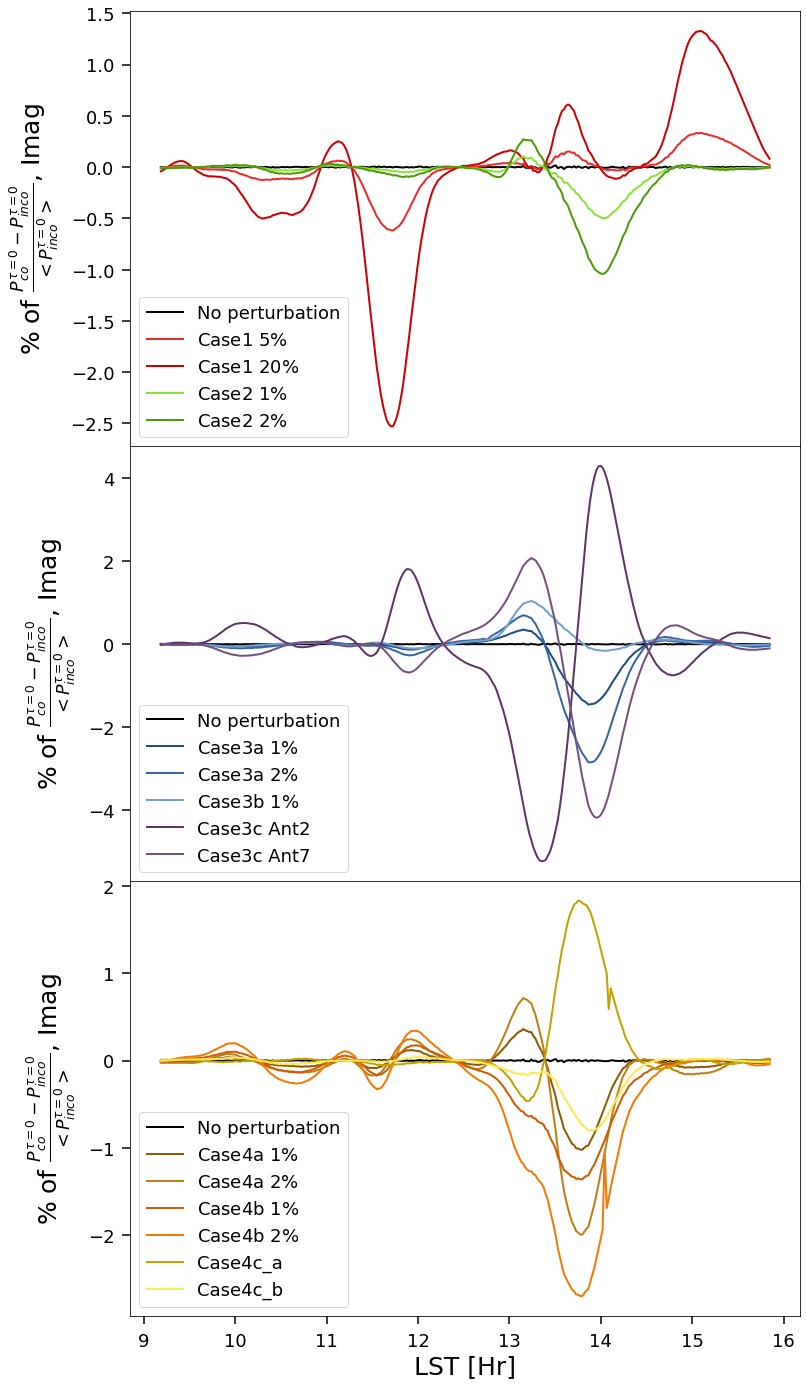

In [23]:
fig, ax = plt.subplots(3, 1, sharex=True,figsize=(12, 24))

plot_diff_inco_co_from_pspeccon_stat_imag("calibration.realiz/viscatBC_g.inco_psc.hdf5",
                                      "calibration.realiz/viscatBC_g.co_psc.hdf5",
                                     ax=ax[0],color='k',label=r'No perturbation')
plot_diff_inco_co_from_pspeccon_stat_imag("calibration.realiz/viscatBC_side0.05_g.inco_psc.hdf5",
                                      "calibration.realiz/viscatBC_side0.05_g.co_psc.hdf5",
                                     ax=ax[0],color='#ef2929',label=r'Case1 $5\%$')
plot_diff_inco_co_from_pspeccon_stat_imag("calibration.realiz/viscatBC_side0.2_g.inco_psc.hdf5",
                                      "calibration.realiz/viscatBC_side0.2_g.co_psc.hdf5",
                                          ax=ax[0],color='#cc0000',label=r'Case1 $20\%$')
plot_diff_inco_co_from_pspeccon_stat_imag("calibration.realiz/viscatBC_main001_g.inco_psc.hdf5",
                                      "calibration.realiz/viscatBC_main001_g.co_psc.hdf5",
                                          ax=ax[0],color='#8ae234',label=r'Case2 $1\%$')
plot_diff_inco_co_from_pspeccon_stat_imag("calibration.realiz/viscatBC_main002_g.inco_psc.hdf5",
                                      "calibration.realiz/viscatBC_main002_g.co_psc.hdf5",
                                          ax=ax[0],color='#4e9a06',label=r'Case2 $2\%$')

plot_diff_inco_co_from_pspeccon_stat_imag("calibration.realiz/viscatBC_g.inco_psc.hdf5",
                                      "calibration.realiz/viscatBC_g.co_psc.hdf5",
                                     ax=ax[1],color='k',label=r'No perturbation')
plot_diff_inco_co_from_pspeccon_stat_imag("calibration.realiz/viscatBC_stretch0.01_g.inco_psc.hdf5",
                                      "calibration.realiz/viscatBC_stretch0.01_g.co_psc.hdf5",
                                          ax=ax[1],color='#204a87',label=r'Case3a $1\%$')
plot_diff_inco_co_from_pspeccon_stat_imag("calibration.realiz/viscatBC_stretch0.02_g.inco_psc.hdf5",
                                      "calibration.realiz/viscatBC_stretch0.02_g.co_psc.hdf5",
                                          ax=ax[1],color='#3465a4',label=r'Case3a $2\%$')
plot_diff_inco_co_from_pspeccon_stat_imag("calibration.realiz/viscatBC_unistretch0.01_g.inco_psc.hdf5",
                                      "calibration.realiz/viscatBC_unistretch0.01_g.co_psc.hdf5",
                                          ax=ax[1],color='#729fcf',label=r'Case3b $1\%$')
plot_diff_inco_co_from_pspeccon_stat_imag("calibration.realiz/viscatBC_outlier2_1.1_g.inco_psc.hdf5",
                                      "calibration.realiz/viscatBC_outlier2_1.1_g.co_psc.hdf5",
                                          ax=ax[1],color='#5c3566',label=r'Case3c Ant2')
plot_diff_inco_co_from_pspeccon_stat_imag("calibration.realiz/viscatBC_outlier7_1.1_g.inco_psc.hdf5",
                                      "calibration.realiz/viscatBC_outlier7_1.1_g.co_psc.hdf5",
                                          ax=ax[1],color='#75507b',label=r'Case3c Ant7')


plot_diff_inco_co_from_pspeccon_stat_imag("calibration.realiz/viscatBC_g.inco_psc.hdf5",
                                      "calibration.realiz/viscatBC_g.co_psc.hdf5",
                                     ax=ax[2],color='k',label=r'No perturbation')
plot_diff_inco_co_from_pspeccon_stat_imag("calibration.realiz/viscatBC_4a_0.01_g.inco_psc.hdf5",
                                      "calibration.realiz/viscatBC_4a_0.01_g.co_psc.hdf5",
                                          ax=ax[2],color='#8f5902',label=r'Case4a $1\%$')
plot_diff_inco_co_from_pspeccon_stat_imag("calibration.realiz/viscatBC_4a_0.02_g.inco_psc.hdf5",
                                      "calibration.realiz/viscatBC_4a_0.02_g.co_psc.hdf5",
                                          ax=ax[2],color='#c17d11',label=r'Case4a $2\%$')
plot_diff_inco_co_from_pspeccon_stat_imag("calibration.realiz/viscatBC_4b_0.01_g.inco_psc.hdf5",
                                      "calibration.realiz/viscatBC_4b_0.01_g.co_psc.hdf5",
                                          ax=ax[2],color='#ce5c00',label=r'Case4b $1\%$')
plot_diff_inco_co_from_pspeccon_stat_imag("calibration.realiz/viscatBC_4b_0.02_g.inco_psc.hdf5",
                                      "calibration.realiz/viscatBC_4b_0.02_g.co_psc.hdf5",
                                          ax=ax[2],color='#f57900',label=r'Case4b $2\%$')
plot_diff_inco_co_from_pspeccon_stat_imag("calibration.realiz/viscatBC_4c_a_g.inco_psc.hdf5",
                                      "calibration.realiz/viscatBC_4c_a_g.co_psc.hdf5",
                                          ax=ax[2],color='#c4a000',label=r'Case4c_a')
plot_diff_inco_co_from_pspeccon_stat_imag("calibration.realiz/viscatBC_4c_b_g.inco_psc.hdf5",
                                      "calibration.realiz/viscatBC_4c_b_g.co_psc.hdf5",
                                          ax=ax[2],color='#fce94f',label=r'Case4c_b')

plt.subplots_adjust(hspace=0)
plt.savefig('decorr_imag.pdf',bbox_inches='tight')

In [24]:
def var_plot(uvd_file,ymin=None,ymax=None,label=None,color=None,ax=None):
    uvd_in = UVData()
    uvd_in.read_uvh5(uvd_file)

    red_bls = hp.utils.get_reds(uvd_in)[0][2]

    vis = []
    for bl in red_bls:
        vis.append(uvd_in.get_data(bl))
    vis = np.array(vis)
    var = np.var(np.real(vis), axis=0)

    new_plot = False
    if ax is None:
        new_plot = True
        fig, ax = plt.subplots(figsize=(12,8))
     
    lsts = np.unique(uvd_in.time_array)
    nlsts = lsts.size
    
    obs_t=Time(lsts, format='jd',location=hera_location)
    lsts_hr = obs_t.sidereal_time('mean').hour
        
    ax.plot(lsts_hr,var[:,60],color=color,label=label)
    ax.set_yscale('log')
    ax.set_ylabel(r"Visibility Variance (Re)", fontsize=25,labelpad=10)
    ax.set_xlabel("LST [Hr]", fontsize=25)
    #ax.set_ylim(ymin,ymax)
    ax.tick_params(axis='both', which='major', labelsize=18, size=8., width=1.5, pad=8.)
    ax.tick_params(axis='both', which='minor', labelsize=18, size=5., width=1.5, pad=8.)
    ax.legend(loc='upper left',fontsize=18)
    
    if new_plot:
        return fig

Telescope hera_sim is not in known_telescopes.
Telescope hera_sim is not in known_telescopes.


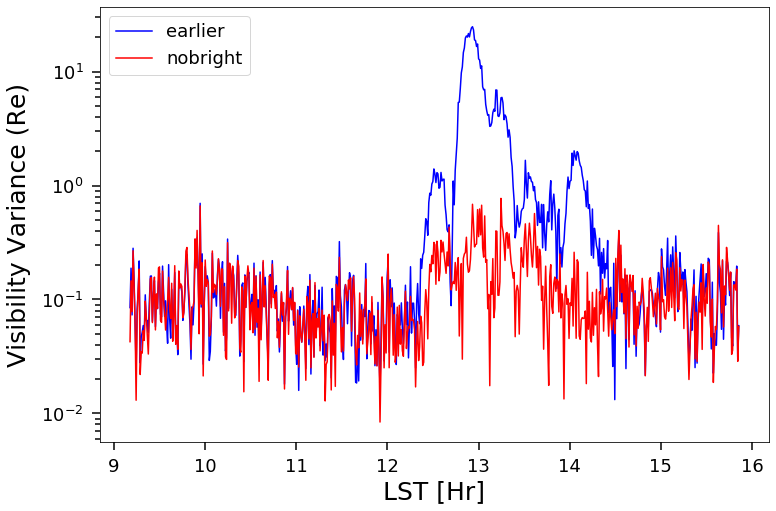

In [25]:
fig = var_plot("calibration_catBC/viscatBC_main002_g_cal.uvh5",color='b',label=r'earlier')
#var_plot("calibration_catBC/viscatBC_main002.uvh5",ax=fig.gca(),color='k',label=r'earlier_withoutnoise')
var_plot("calibration/viscatBC_main002_g_cal.uvh5",ax=fig.gca(),color='r',label=r'nobright')
#var_plot("calibration/viscatBC_main002.uvh5",ax=fig.gca(),color='g',label=r'nobright_withoutnoise')

Telescope hera_sim is not in known_telescopes.
Telescope hera_sim is not in known_telescopes.


Text(0.5, 1.0, 'sidelobe')

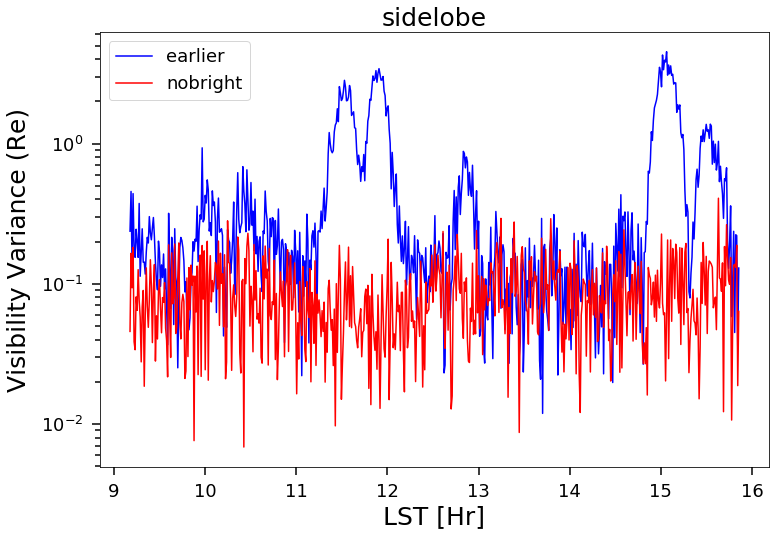

In [26]:
fig = var_plot("calibration_catBC/viscatBC_side0.2_g_cal.uvh5",color='b',label=r'earlier')
#var_plot("calibration_catBC/viscatBC_main002.uvh5",ax=fig.gca(),color='k',label=r'earlier_withoutnoise')
var_plot("calibration/viscatBC_side0.2_g_cal.uvh5",ax=fig.gca(),color='r',label=r'nobright')
#var_plot("calibration/viscatBC_main002.uvh5",ax=fig.gca(),color='g',label=r'nobright_withoutnoise')
plt.title('sidelobe',fontsize=25)

Telescope hera_sim is not in known_telescopes.
Telescope hera_sim is not in known_telescopes.


Text(0.5, 1.0, 'stretch0.02')

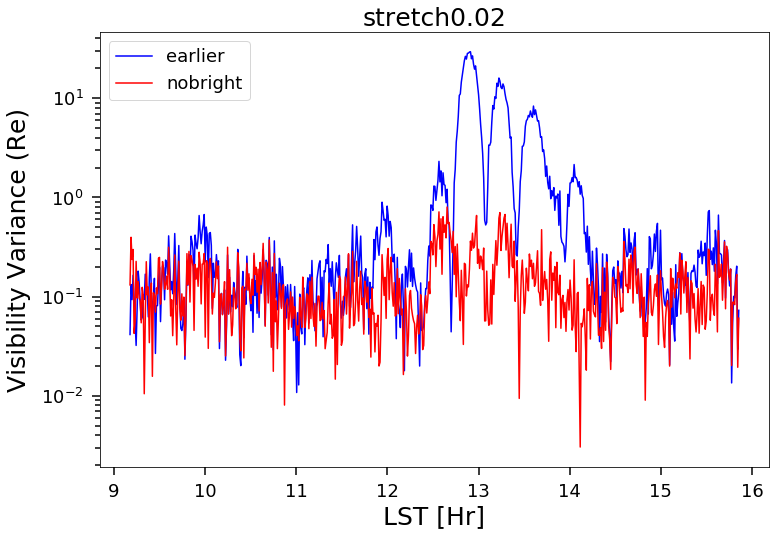

In [27]:
fig = var_plot("calibration_catBC/viscatBC_stretch0.02_g_cal.uvh5",color='b',label=r'earlier')
#var_plot("calibration_catBC/viscatBC_main002.uvh5",ax=fig.gca(),color='k',label=r'earlier_withoutnoise')
var_plot("calibration/viscatBC_stretch0.02_g_cal.uvh5",ax=fig.gca(),color='r',label=r'nobright')
#var_plot("calibration/viscatBC_main002.uvh5",ax=fig.gca(),color='g',label=r'nobright_withoutnoise')
plt.title('stretch0.02',fontsize=25)

Telescope hera_sim is not in known_telescopes.
Telescope hera_sim is not in known_telescopes.


Text(0.5, 1.0, 'ellipticity')

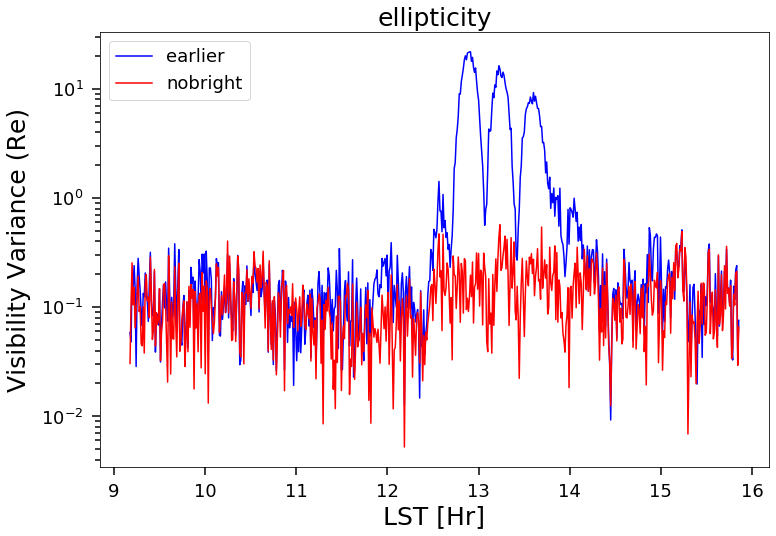

In [28]:
fig = var_plot("calibration_catBC/viscatBC_4a_0.02_g_cal.uvh5",color='b',label=r'earlier')
#var_plot("calibration_catBC/viscatBC_main002.uvh5",ax=fig.gca(),color='k',label=r'earlier_withoutnoise')
var_plot("calibration/viscatBC_4a_0.02_g_cal.uvh5",ax=fig.gca(),color='r',label=r'nobright')
#var_plot("calibration/viscatBC_main002.uvh5",ax=fig.gca(),color='g',label=r'nobright_withoutnoise')
plt.title('ellipticity',fontsize=25)

Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part


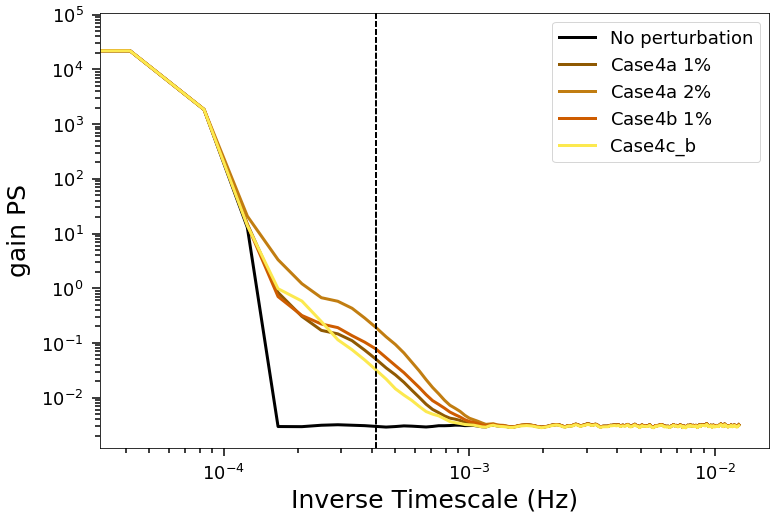

In [41]:
fig, ax = plt.subplots(1, 1, sharex=True,figsize=(12, 8))

gain_PS("calibration_catBC/viscatBC_g_new.calfits",color='k',ax=ax,label=r'No perturbation')
gain_PS("calibration_catBC/viscatBC_4a_0.01_g_new.calfits",ax=ax,color='#8f5902',label=r'Case4a $1\%$')
gain_PS("calibration_catBC/viscatBC_4a_0.02_g_new.calfits",ax=ax,color='#c17d11',label=r'Case4a $2\%$')
gain_PS("calibration_catBC/viscatBC_4b_0.01_g_new.calfits",ax=ax,color='#ce5c00',label=r'Case4b $1\%$')
#gain_PS("calibration_catBC/viscatBC_4b_0.02_g_new.calfits",ax=ax,color='#f57900',label=r'Case4b $2\%$')
#gain_PS("calibration_catBC/viscatBC_4c_a_g_new.calfits",ax=ax,color='#c4a000',label=r'Case4c_a')
gain_PS("calibration_catBC/viscatBC_4c_b_g_new.calfits",ax=ax,color='#fce94f',label=r'Case4c_b')

Telescope hera_sim is not in known_telescopes.
Telescope hera_sim is not in known_telescopes.
Telescope hera_sim is not in known_telescopes.
Telescope hera_sim is not in known_telescopes.
Telescope hera_sim is not in known_telescopes.
Telescope hera_sim is not in known_telescopes.
Telescope hera_sim is not in known_telescopes.
Telescope hera_sim is not in known_telescopes.
Telescope hera_sim is not in known_telescopes.
Telescope hera_sim is not in known_telescopes.
Telescope hera_sim is not in known_telescopes.
Telescope hera_sim is not in known_telescopes.
Telescope hera_sim is not in known_telescopes.
Telescope hera_sim is not in known_telescopes.
Telescope hera_sim is not in known_telescopes.
Telescope hera_sim is not in known_telescopes.
Telescope hera_sim is not in known_telescopes.
Telescope hera_sim is not in known_telescopes.


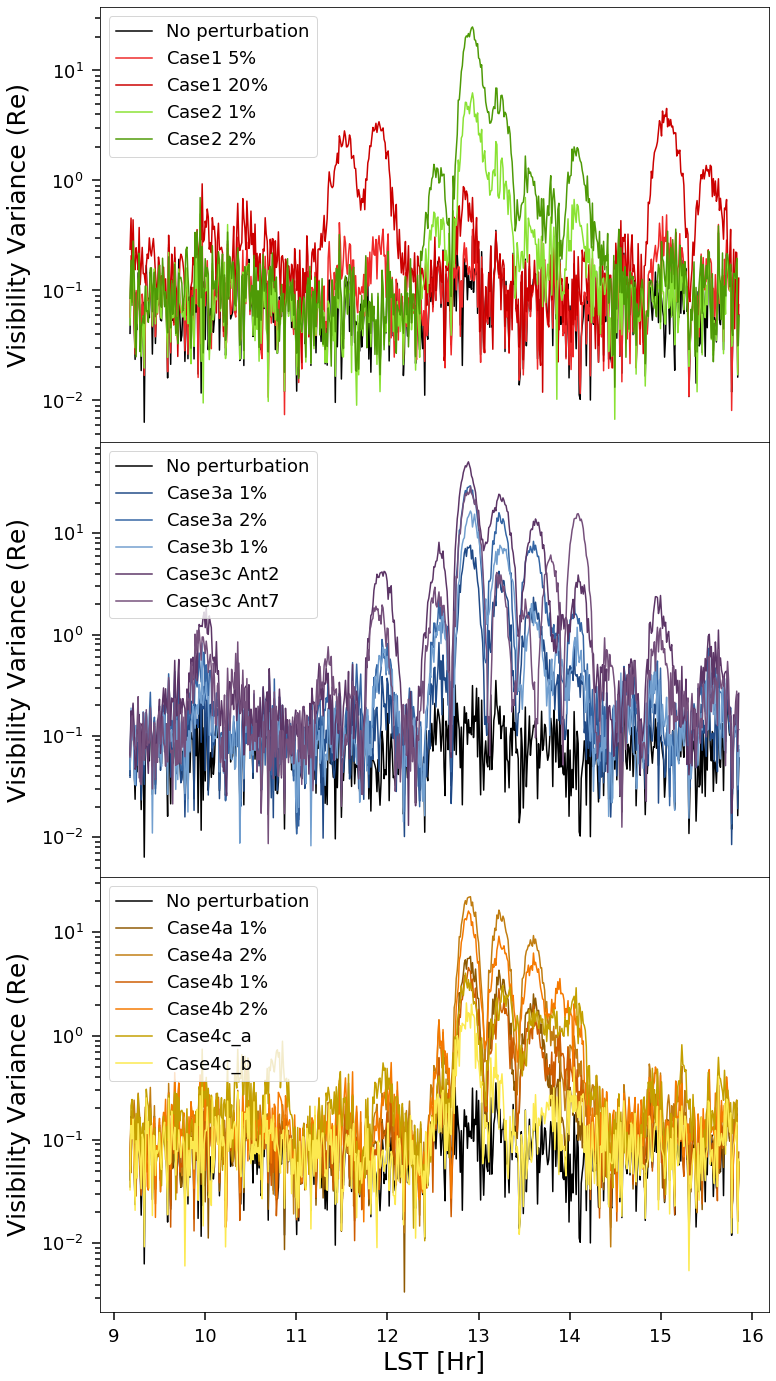

In [30]:
fig, ax = plt.subplots(3, 1, sharex=True,figsize=(12, 24))

var_plot("calibration_catBC/viscatBC_g_cal.uvh5",color='k',ax=ax[0],label=r'No perturbation')
var_plot("calibration_catBC/viscatBC_side0.05_g_cal.uvh5",ax=ax[0],color='#ef2929',label=r'Case1 $5\%$')
var_plot("calibration_catBC/viscatBC_side0.2_g_cal.uvh5",ax=ax[0],color='#cc0000',label=r'Case1 $20\%$')
var_plot("calibration_catBC/viscatBC_main001_g_cal.uvh5",ax=ax[0],color='#8ae234',label=r'Case2 $1\%$')
var_plot("calibration_catBC/viscatBC_main002_g_cal.uvh5",ax=ax[0],color='#4e9a06',label=r'Case2 $2\%$')


var_plot("calibration_catBC/viscatBC_g_cal.uvh5",ax=ax[1],color='k',label=r'No perturbation')
var_plot("calibration_catBC/viscatBC_stretch0.01_g_cal.uvh5",ax=ax[1],color='#204a87',
         label=r'Case3a $1\%$')
var_plot("calibration_catBC/viscatBC_stretch0.02_g_cal.uvh5",ax=ax[1],color='#3465a4',
         label=r'Case3a $2\%$')
var_plot("calibration_catBC/viscatBC_unistretch0.01_g_cal.uvh5",ax=ax[1],color='#729fcf',
         label=r'Case3b $1\%$')
var_plot("calibration_catBC/viscatBC_outlier2_1.1_g_cal.uvh5",ax=ax[1],color='#5c3566',label=r'Case3c Ant2')
var_plot("calibration_catBC/viscatBC_outlier7_1.1_g_cal.uvh5",ax=ax[1],color='#75507b',label=r'Case3c Ant7')


var_plot("calibration_catBC/viscatBC_g_cal.uvh5",ax=ax[2],color='k',label=r'No perturbation')
var_plot("calibration_catBC/viscatBC_4a_0.01_g_cal.uvh5",ax=ax[2],color='#8f5902',label=r'Case4a $1\%$')
var_plot("calibration_catBC/viscatBC_4a_0.02_g_cal.uvh5",ax=ax[2],color='#c17d11',label=r'Case4a $2\%$')
var_plot("calibration_catBC/viscatBC_4b_0.01_g_cal.uvh5",ax=ax[2],color='#ce5c00',label=r'Case4b $1\%$')
var_plot("calibration_catBC/viscatBC_4b_0.02_g_cal.uvh5",ax=ax[2],color='#f57900',label=r'Case4b $2\%$')
var_plot("calibration_catBC/viscatBC_4c_a_g_cal.uvh5",ax=ax[2],color='#c4a000',label=r'Case4c_a')
var_plot("calibration_catBC/viscatBC_4c_b_g_cal.uvh5",ax=ax[2],color='#fce94f',label=r'Case4c_b')

plt.subplots_adjust(hspace=0)
plt.savefig('var_real.pdf',bbox_inches='tight')

In [33]:
#!rm -rf *.pdf